#**0_Preparation**#

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ['KAGGLE_USERNAME'] = "financepark"
os.environ['KAGGLE_KEY'] = "bdbd2d4123356ced7712d5e0df68bdaf"

!kaggle datasets download -d arunrk7/surface-crack-detection
!unzip -q surface-crack-detection.zip


 97% 226M/233M [00:01<00:00, 202MB/s]
100% 233M/233M [00:01<00:00, 177MB/s]


In [2]:
print(len(os.listdir("Positive")))
print(len(os.listdir("Positive")))

20000
20000


In [3]:
import os
import zipfile
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import random
import numpy as np
from google.colab import files
from keras.preprocessing import image
from keras.metrics import Recall
!kaggle datasets download -d keras/inceptionv3
!unzip -q inceptionv3.zip
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
random.seed(821)

 92% 149M/162M [00:00<00:00, 155MB/s]
100% 162M/162M [00:00<00:00, 178MB/s]


In [4]:
!pip install opencv-python

In [5]:
os.mkdir('/tmp/concrete')
os.mkdir('/tmp/concrete/training')
os.mkdir('/tmp/concrete/testing')
os.mkdir('/tmp/concrete/valid')
os.mkdir('/tmp/concrete/training/positive')
os.mkdir('/tmp/concrete/training/negative')
os.mkdir('/tmp/concrete/testing/positive')
os.mkdir('/tmp/concrete/testing/negative')
os.mkdir('/tmp/concrete/valid/positive')
os.mkdir('/tmp/concrete/valid/negative')
os.mkdir('/tmp/checkpoint')



In [6]:
def split_data(SOURCE,TRAINING,VALID,TESTING,TRAINING_SIZE,VALID_SIZE):
    files=[]
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + "is zero length, so ignoring.")
    training_length = int(len(files)*TRAINING_SIZE)
    valid_length = int(len(files)*VALID_SIZE)
    testing_length = int(len(files)-training_length-valid_length)
    shuffled_set = random.sample(files,len(files))
    valid_set = shuffled_set[0:valid_length]
    training_set = shuffled_set[valid_length:-testing_length]
    testing_set = shuffled_set[-testing_length:]
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file,destination)
    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALID + filename
        copyfile(this_file,destination)
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file,destination)
        
POSITIVE_SOURCE_DIR = "/content/Positive/"
NEGATIVE_SOURCE_DIR = "/content/Negative/"
TRAINING_POSITIVE_DIR = '/tmp/concrete/training/positive/'  
TRAINING_NEGATIVE_DIR = '/tmp/concrete/training/negative/'   
VALID_POSITIVE_DIR = '/tmp/concrete/valid/positive/'  
VALID_NEGATIVE_DIR = '/tmp/concrete/valid/negative/'   
TESTING_POSITIVE_DIR = '/tmp/concrete/testing/positive/'
TESTING_NEGATIVE_DIR = '/tmp/concrete/testing/negative/'

# Since we have set the train/val/test ratio as 6:2:2,
training_size = 0.6
valid_size = 0.2
split_data(POSITIVE_SOURCE_DIR, TRAINING_POSITIVE_DIR, VALID_POSITIVE_DIR,TESTING_POSITIVE_DIR, training_size, valid_size)
split_data(NEGATIVE_SOURCE_DIR, TRAINING_NEGATIVE_DIR, VALID_NEGATIVE_DIR,TESTING_NEGATIVE_DIR, training_size, valid_size)

In [7]:
print(len(os.listdir('/tmp/concrete/training/positive/')))
print(len(os.listdir('/tmp/concrete/training/negative/')))
print(len(os.listdir('/tmp/concrete/testing/positive/')))
print(len(os.listdir('/tmp/concrete/testing/negative/')))
print(len(os.listdir('/tmp/concrete/valid/positive/')))
print(len(os.listdir('/tmp/concrete/valid/negative/')))

12000
12000
4000
4000
4000
4000


#**1_InceptionV3 (Adam)**#

*   dropout = 0.1 / (0.3) 
*   loss = binary_crossentropy
*   optimizer = Adam(learning_rate = 0.1 / 0.01)
*   epoch = Earlystopping(maximize val_recall / patience=10)





In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

def InceptionV3_adam(dropout, learning_rate,epochs):
  pre_trained_model = tf.keras.applications.InceptionV3(input_shape = (227, 227, 3), 
                                include_top = False, 
                                weights = None)
  pre_trained_model.load_weights(local_weights_file)
  for layer in pre_trained_model.layers: 
   layer.trainable = False
  last_layer = pre_trained_model.get_layer('mixed7') 
  last_output = last_layer.output
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(dropout)(x)                  
  x = layers.Dense  (1, activation='sigmoid')(x)           
  model = Model(pre_trained_model.input, x)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 64, class_mode = 'binary', target_size = (227,227))

  model.compile(optimizer = keras.optimizers.Adam(lr=learning_rate), # RMSprop(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)
  history = model.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc])
    # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("Epochs here are :", len(rec))
  fig, ax = plt.subplots(2, 1)
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)



Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 108s 192ms/step - loss: 161.1585 - recall: 0.9668 - val_loss: 20.5515 - val_recall: 0.9990
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 74s 198ms/step - loss: 10.5086 - recall: 0.9961 - val_loss: 7.3285 - val_recall: 0.9990
Epoch 3/100
375/375 [==============================] - 72s 192ms/step - loss: 5.0569 - recall: 0.9978 - val_loss: 22.5284 - val_recall: 0.9995
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/100
375/375 [==============================] - 73s 194ms/step - loss: 5.9668 - recall: 0.9978 - val_loss: 124.3039 - val_recall: 0.9995
Epoch 5/100
375/375 [==============================] - 72s 192ms/step - loss: 10.3991 - recall: 0.9984 - val_loss: 29.6045 - val_recall: 0.9983
Epoch 6/100
375/375 [==============================] - 73s 194ms/step - loss: 13.5200 - recall: 0.9989 - val_loss: 10.2099 - val_recall: 0.9980
Epoch 7/100
375/375 

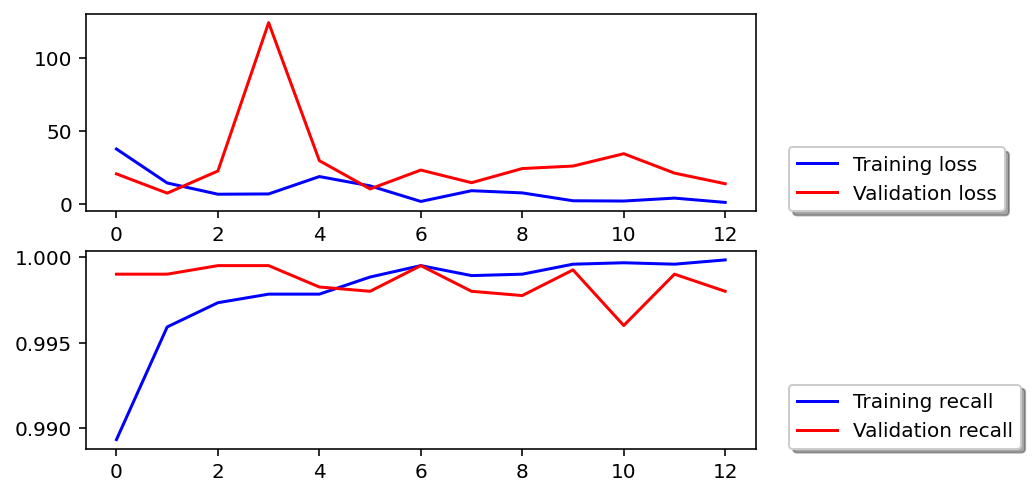

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) Adam optimizer(learning rate = 0.1) 
InceptionV3_adam(0.1,0.1,100)

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 77s 195ms/step - loss: 4.2597 - recall: 0.9685 - val_loss: 0.0383 - val_recall: 0.9975
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 71s 190ms/step - loss: 0.0125 - recall: 0.9992 - val_loss: 0.0451 - val_recall: 0.9983
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 81s 217ms/step - loss: 0.2478 - recall: 0.9974 - val_loss: 11.6632 - val_recall: 0.9672
Epoch 4/100
375/375 [==============================] - 82s 218ms/step - loss: 1.1578 - recall: 0.9970 - val_loss: 0.7279 - val_recall: 0.9990
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/100
375/375 [==============================] - 71s 189ms/step - loss: 0.0641 - recall: 0.9994 - val_loss: 0.1672 - val_recall: 0.9985
Epoch 6/100
375/375 [==============================] - 71s 190ms/step - loss: 0.0307 - recall: 0.9996 - val_loss: 0

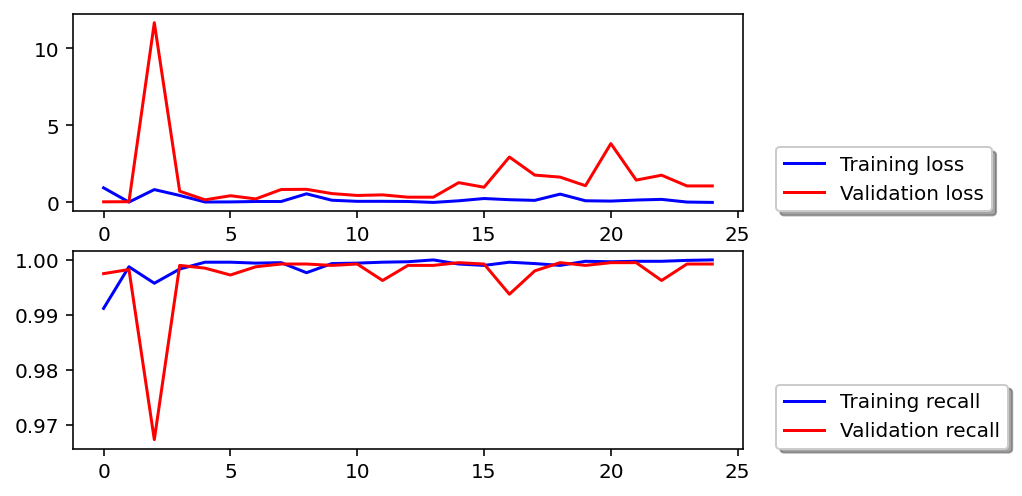

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) Adam optimizer(learning rate = 0.01) 
InceptionV3_adam(0.1,0.01,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) Adam optimizer(learning rate = 0.1) 
# InceptionV3_adam(0.3,0.1,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) Adam optimizer(learning rate = 0.01) 
# InceptionV3_adam(0.3,0.01,100)

#**2_InceptionV3 (MomentumSGD)**#

*   dropout = 0.1 / (0.3) 
*   loss = binary_crossentropy
*   optimizer = MomentumSGD(learning_rate = 0.1 / 0.01)
*   epoch = Earlystopping(maximize val_recall / patience=10)





In [ ]:
def InceptionV3_momentumSGD(dropout, learning_rate,epochs):
  pre_trained_model = tf.keras.applications.InceptionV3(input_shape = (227, 227, 3), 
                                include_top = False, 
                                weights = None)
  pre_trained_model.load_weights(local_weights_file)
  for layer in pre_trained_model.layers: 
   layer.trainable = False
  last_layer = pre_trained_model.get_layer('mixed7') 
  last_output = last_layer.output
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(dropout)(x)                  
  x = layers.Dense  (1, activation='sigmoid')(x)           
  model = Model(pre_trained_model.input, x)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 64, class_mode = 'binary', target_size = (227,227))

  model.compile(optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9), # RMSprop(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)
  history = model.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc])
  
  # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("Epochs here are :", len(rec))
  fig, ax = plt.subplots(2, 1)
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)


Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 74s 190ms/step - loss: 24.8839 - recall: 0.6277 - val_loss: 0.6964 - val_recall: 1.0000
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 70s 186ms/step - loss: 0.6528 - recall: 0.5357 - val_loss: 0.0588 - val_recall: 0.9902
Epoch 3/100
375/375 [==============================] - 70s 186ms/step - loss: 0.1823 - recall: 0.8949 - val_loss: 0.0544 - val_recall: 0.9952
Epoch 4/100
375/375 [==============================] - 70s 187ms/step - loss: 0.1730 - recall: 0.8965 - val_loss: 0.0560 - val_recall: 0.9965
Epoch 5/100
375/375 [==============================] - 70s 187ms/step - loss: 0.1744 - recall: 0.8953 - val_loss: 0.0548 - val_recall: 0.9980
Epoch 6/100
375/375 [==============================] - 70s 186ms/step - loss: 0.1726 - recall: 0.8978 - val_loss: 0.0466 - val_recall: 0.9975
Epoch 7/100
375/375 [==============================] - 70s 187ms/step - loss: 0.1681 - re

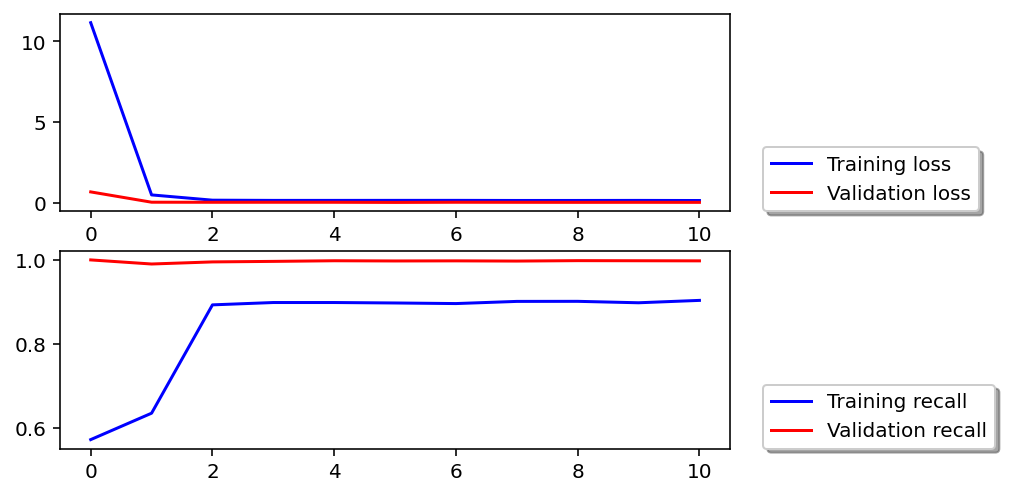

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) MomentumSGD optimizer(learning rate = 0.1) 
InceptionV3_momentumSGD(0.1,0.1,100)

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 78s 200ms/step - loss: 0.0975 - recall: 0.9554 - val_loss: 0.0064 - val_recall: 0.9983
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 81s 217ms/step - loss: 0.0059 - recall: 0.9986 - val_loss: 0.0055 - val_recall: 0.9980
Epoch 3/100
375/375 [==============================] - 80s 214ms/step - loss: 0.0024 - recall: 0.9995 - val_loss: 0.0055 - val_recall: 0.9980
Epoch 4/100
375/375 [==============================] - 81s 216ms/step - loss: 0.0010 - recall: 0.9997 - val_loss: 0.0074 - val_recall: 0.9990
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/100
375/375 [==============================] - 69s 185ms/step - loss: 0.0011 - recall: 0.9999 - val_loss: 0.0057 - val_recall: 0.9980
Epoch 6/100
375/375 [==============================] - 70s 186ms/step - loss: 6.2344e-04 - recall: 0.9998 - val_loss: 0.0052 - val_recall: 0.9985
Epoch 7/100
375/375 [=======

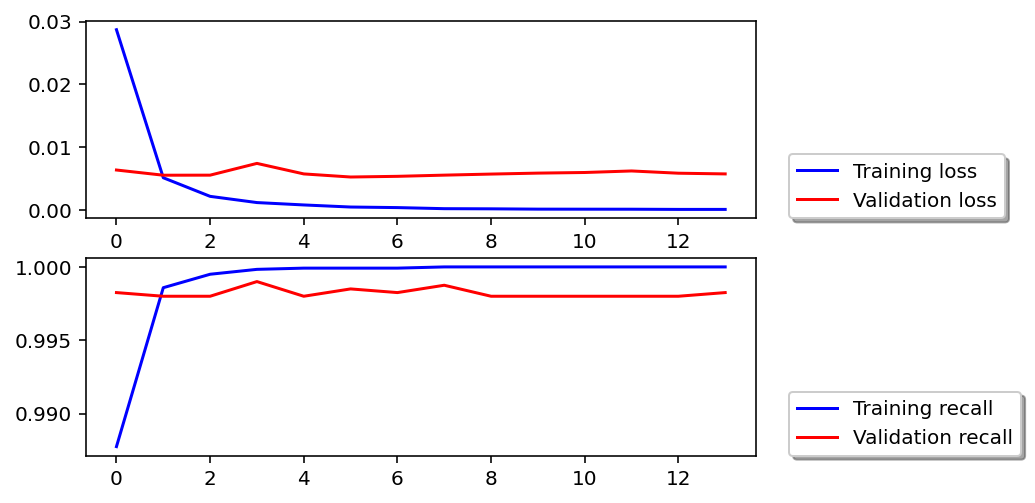

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) MomentumSGD optimizer(learning rate = 0.01) 
InceptionV3_momentumSGD(0.1,0.01,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) MomentumSGD optimizer(learning rate = 0.01) 
#InceptionV3_momentumSGD(0.3,0.1,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) MomentumSGD optimizer(learning rate = 0.01) 
#InceptionV3_momentumSGD(0.3,0.01,100)

#**3_InceptionV3 (Minibatch SGD)**#

*   dropout = 0.1 / (0.3) 
*   loss = binary_crossentropy
*   optimizer = Minibatch SGD(batch_size=16 , lr=0.1 / 0.01)
*   epoch = Earlystopping(maximize val_recall / patience=10)








In [ ]:
def InceptionV3_minibatchSGD(dropout, learning_rate,epochs):
  pre_trained_model = tf.keras.applications.InceptionV3(input_shape = (227, 227, 3), 
                                include_top = False, 
                                weights = None)
  pre_trained_model.load_weights(local_weights_file)
  for layer in pre_trained_model.layers: 
    layer.trainable = False
  last_layer = pre_trained_model.get_layer('mixed7') 
  last_output = last_layer.output
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(dropout)(x)                  
  x = layers.Dense  (1, activation='sigmoid')(x)           
  model = Model(pre_trained_model.input, x)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 16, class_mode = 'binary', target_size = (227,227))
  
  # 테스트셋 준비
  TESTING_DIR = '/tmp/concrete/testing/'
  test_datagen = ImageDataGenerator(rescale = 1./255)
  test_generator = test_datagen.flow_from_directory(TESTING_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')


  checkpoint_path = 'here/checkpoint-{epoch:04d}.ckpt'
  checkpoint_dir = os.path.dirname(checkpoint_path)
  print(checkpoint_dir)

  # checkpoint_path 포맷을 사용하는 가중치를 저장
  model.save_weights(checkpoint_path.format(epoch=0))

  model.compile(optimizer = keras.optimizers.SGD(lr=learning_rate), # RMSprop(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)
  history = model.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc])
  
  # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("Epochs here are :", len(rec))
  fig, ax = plt.subplots(2, 1)
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)

  return model


Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1500/1500 [==============================] - 94s 60ms/step - loss: 0.8135 - recall: 0.5253 - val_loss: 0.5838 - val_recall: 0.9945
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
1500/1500 [==============================] - 86s 57ms/step - loss: 0.6930 - recall: 0.3779 - val_loss: 0.6932 - val_recall: 0.0000e+00
Epoch 3/100
1500/1500 [==============================] - 85s 57ms/step - loss: 0.6460 - recall: 0.5738 - val_loss: 0.0672 - val_recall: 0.9870
Epoch 4/100
1500/1500 [==============================] - 85s 57ms/step - loss: 0.1775 - recall: 0.8940 - val_loss: 0.0496 - val_recall: 0.9983
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/100
1500/1500 [==============================] - 98s 65ms/step - loss: 0.1697 - recall: 0.8997 - val_loss: 0.0545 - val_recall: 0.9992
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 6/100
1500/1500 [==============================] - 98s 65ms/step - loss: 0.1595 - recall: 0.9063 - val_loss: 0.02

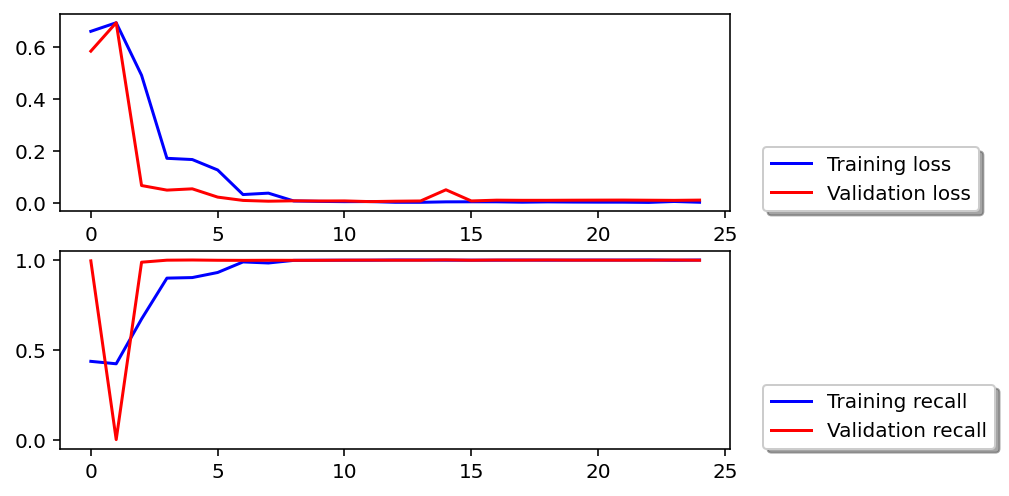

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) MinibatchSGD optimizer(learning rate = 0.1) 
InceptionV3_minibatchSGD(0.1,0.1,100)

평가 - 테스트 셋

In [25]:
def InceptionV3_minibatchSGD_test(dropout, learning_rate,epochs):
  pre_trained_model = tf.keras.applications.InceptionV3(input_shape = (227, 227, 3), 
                                include_top = False, 
                                weights = None)
  pre_trained_model.load_weights(local_weights_file)
  for layer in pre_trained_model.layers: 
    layer.trainable = False
  last_layer = pre_trained_model.get_layer('mixed7') 
  last_output = last_layer.output
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(dropout)(x)                  
  x = layers.Dense  (1, activation='sigmoid')(x)           
  model = Model(pre_trained_model.input, x)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 16, class_mode = 'binary', target_size = (227,227))


  checkpoint_path = 'here/checkpoint-{epoch:04d}.ckpt'
  checkpoint_dir = os.path.dirname(checkpoint_path)
  print(checkpoint_dir)

  # checkpoint_path 포맷을 사용하는 가중치를 저장
  model.save_weights(checkpoint_path.format(epoch=0))

  model.compile(optimizer = keras.optimizers.SGD(lr=learning_rate), # RMSprop(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc=ModelCheckpoint(checkpoint_path, monitor='val_recall', mode='max', save_weights_only=True)
  history = model.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc])
  
  # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("Epochs here are :", len(rec))
  fig, ax = plt.subplots(2, 1)
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)

  return model, checkpoint_dir


Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
here


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1500/1500 [==============================] - 94s 61ms/step - loss: 0.8608 - recall: 0.5513 - val_loss: 0.0557 - val_recall: 0.9950
Epoch 2/100
1500/1500 [==============================] - 102s 68ms/step - loss: 0.1176 - recall: 0.9410 - val_loss: 0.0208 - val_recall: 0.9983
Epoch 3/100
1500/1500 [==============================] - 101s 68ms/step - loss: 0.0350 - recall: 0.9868 - val_loss: 0.0197 - val_recall: 0.9990
Epoch 4/100
1500/1500 [==============================] - 103s 69ms/step - loss: 0.0152 - recall: 0.9957 - val_loss: 0.0101 - val_recall: 0.9987
Epoch 5/100
1500/1500 [==============================] - 104s 69ms/step - loss: 0.0107 - recall: 0.9973 - val_loss: 0.0102 - val_recall: 0.9983
Epoch 6/100
1500/1500 [==============================] - 102s 68ms/step - loss: 0.0052 - recall: 0.9988 - val_loss: 0.0118 - val_recall: 0.9990
Epoch 7/100
1500/1500 [==============================] - 103s 69ms/step - loss: 0.0115 - recall: 0.9960 - val_loss: 0.0096 - val_recall: 

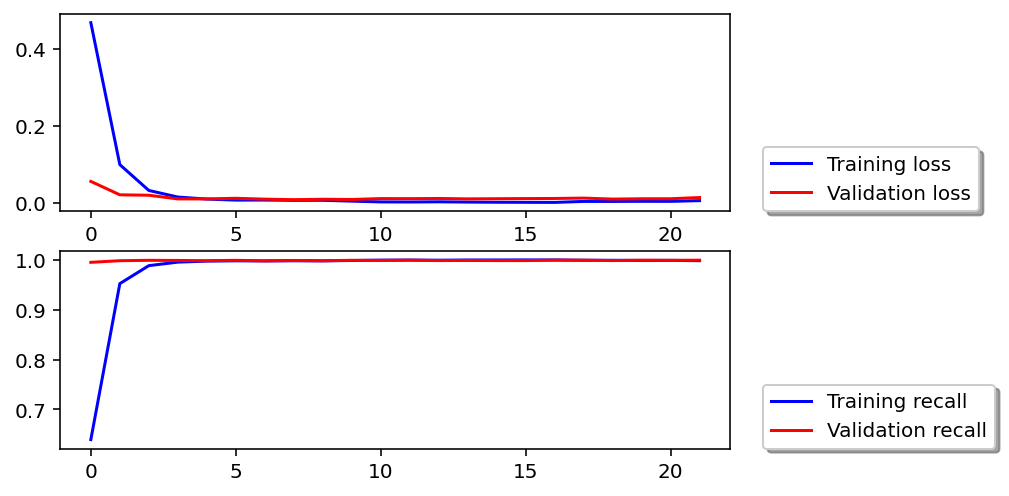

In [26]:
model_test, checkpoint_dir = InceptionV3_minibatchSGD_test(0.1,0.1,100)

In [27]:
# 테스트셋 준비
TESTING_DIR = '/tmp/concrete/testing/'
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(TESTING_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')

Found 8000 images belonging to 2 classes.


In [28]:
ls {checkpoint_dir}

checkpoint
checkpoint-0000.ckpt.data-00000-of-00001
checkpoint-0000.ckpt.index
checkpoint-0001.ckpt/
checkpoint-0001.ckpt.data-00000-of-00001
checkpoint-0001.ckpt.index
checkpoint-0002.ckpt/
checkpoint-0002.ckpt.data-00000-of-00001
checkpoint-0002.ckpt.index
checkpoint-0003.ckpt/
checkpoint-0003.ckpt.data-00000-of-00001
checkpoint-0003.ckpt.index
checkpoint-0004.ckpt.data-00000-of-00001
checkpoint-0004.ckpt.index
checkpoint-0005.ckpt.data-00000-of-00001
checkpoint-0005.ckpt.index
checkpoint-0006.ckpt.data-00000-of-00001
checkpoint-0006.ckpt.index
checkpoint-0007.ckpt.data-00000-of-00001
checkpoint-0007.ckpt.index
checkpoint-0008.ckpt.data-00000-of-00001
checkpoint-0008.ckpt.index
checkpoint-0009.ckpt.data-00000-of-00001
checkpoint-0009.ckpt.index
checkpoint-0010.ckpt.data-00000-of-00001
checkpoint-0010.ckpt.index
checkpoint-0011.ckpt.data-00000-of-00001
checkpoint-0011.ckpt.index
checkpoint-0012.ckpt.data-00000-of-00001
checkpoint-0012.ckpt.index
checkpoint-0013.ckpt.data-00000-of-0000

In [29]:
# 마지막 체크포인트 확인
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'here/checkpoint-0022.ckpt'

In [30]:
model_test.load_weights('here/checkpoint-0012.ckpt')

result = model_test.evaluate(test_generator)

print(result)

500/500 [==============================] - 26s 52ms/step - loss: 0.0111 - recall: 0.9998
[0.011133435182273388, 0.999750018119812]


--------------------------------------------------------------------------------

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1500/1500 [==============================] - 102s 66ms/step - loss: 0.0628 - recall: 0.9768 - val_loss: 0.0066 - val_recall: 0.9985
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
1500/1500 [==============================] - 97s 65ms/step - loss: 0.0042 - recall: 0.9991 - val_loss: 0.0055 - val_recall: 0.9977
Epoch 3/100
1500/1500 [==============================] - 98s 65ms/step - loss: 0.0023 - recall: 0.9995 - val_loss: 0.0049 - val_recall: 0.9983
Epoch 4/100
1500/1500 [==============================] - 100s 67ms/step - loss: 0.0018 - recall: 0.9998 - val_loss: 0.0054 - val_recall: 0.9977
Epoch 5/100
1500/1500 [==============================] - 97s 65ms/step - loss: 0.0013 - recall: 0.9998 - val_loss: 0.0049 - val_recall: 0.9983
Epoch 6/100
1500/1500 [==============================] - 96s 64ms/step - loss: 0.0011 - recall: 0.9997 - val_loss: 0.0049 - val_recall: 0.9983
Epoch 7/100
1500/1500 [==============================] - 96s 64ms/step - loss: 5.9618e-04 - re

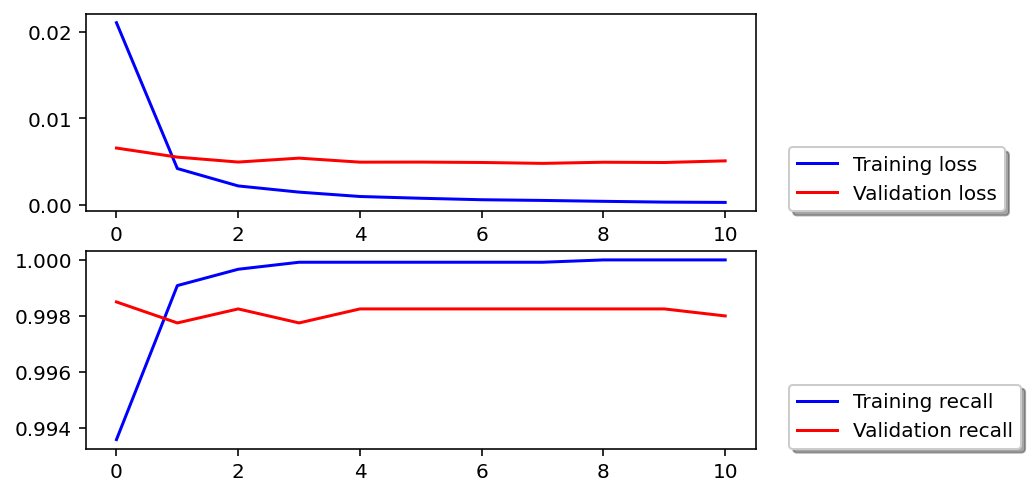

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) MinibatchSGD optimizer(learning rate = 0.01) 
InceptionV3_minibatchSGD(0.1,0.01,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) MinibatchSGD optimizer(learning rate = 0.1) 
#InceptionV3_minibatchSGD(0.3,0.1,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) MinibatchSGD optimizer(learning rate = 0.01) 
#InceptionV3_minibatchSGD(0.3,0.01,100)

#**4_InceptionV3 (RMSprop)**#

*   dropout = 0.1 / (0.3) 
*   loss = binary_crossentropy
*   optimizer = RMSprop(lr=0.1 / 0.01)
*   epoch = Earlystopping(maximize val_recall / patience=10)








In [ ]:
def InceptionV3_RMSprop(dropout, learning_rate,epochs):
  pre_trained_model = tf.keras.applications.InceptionV3(input_shape = (227, 227, 3), 
                                include_top = False, 
                                weights = None)
  pre_trained_model.load_weights(local_weights_file)
  for layer in pre_trained_model.layers: 
   layer.trainable = False
  last_layer = pre_trained_model.get_layer('mixed7') 
  last_output = last_layer.output
  x = layers.Flatten()(last_output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(dropout)(x)                  
  x = layers.Dense  (1, activation='sigmoid')(x)           
  model = Model(pre_trained_model.input, x)

  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 64,class_mode = 'binary', target_size = (227,227))

  model.compile(optimizer = keras.optimizers.RMSprop(lr=learning_rate), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)
  history = model.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc])
  
  # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("Epochs here are :", len(rec))
  fig, ax = plt.subplots(2, 1)
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)


Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 85s 220ms/step - loss: 3026.9036 - recall: 0.9648 - val_loss: 10.6662 - val_recall: 0.9983
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 80s 214ms/step - loss: 37.8474 - recall: 0.9965 - val_loss: 53.0546 - val_recall: 0.9985
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 80s 212ms/step - loss: 26.7750 - recall: 0.9982 - val_loss: 132.0984 - val_recall: 0.9998
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/100
375/375 [==============================] - 80s 213ms/step - loss: 29.8228 - recall: 0.9986 - val_loss: 79.8139 - val_recall: 0.9950
Epoch 5/100
375/375 [==============================] - 80s 213ms/step - loss: 22.1418 - recall: 0.9987 - val_loss: 49.0357 - val_recall: 0.9985
Epoch 6/100
375/375 [==============================] - 80s 213ms/step - loss: 9.3916 - recall: 0.9992 -

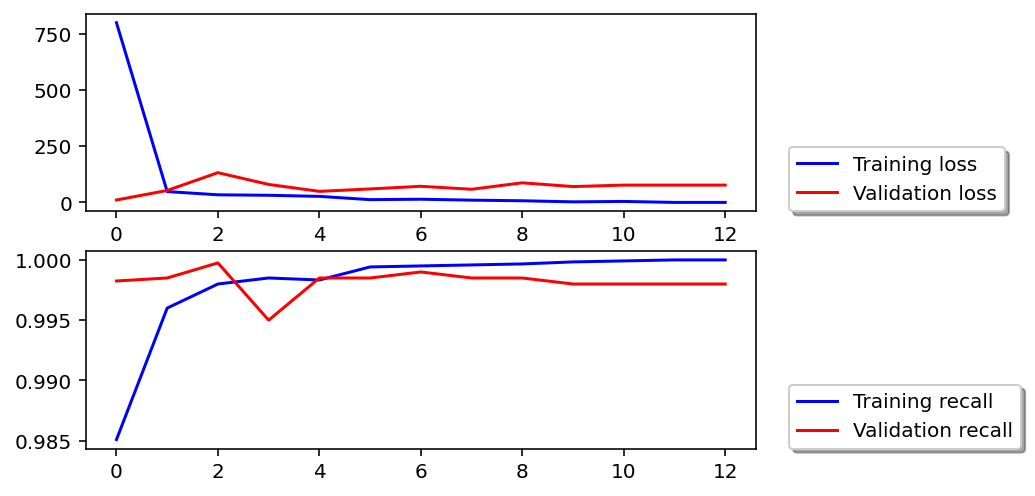

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) RMSprop optimizer(learning rate = 0.1) 
InceptionV3_RMSprop(0.1,0.1,100)

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 84s 217ms/step - loss: 40.4792 - recall: 0.9584 - val_loss: 0.6387 - val_recall: 0.9987
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 79s 211ms/step - loss: 0.9415 - recall: 0.9962 - val_loss: 0.6935 - val_recall: 0.9973
Epoch 3/100
375/375 [==============================] - 80s 212ms/step - loss: 0.8091 - recall: 0.9976 - val_loss: 1.0977 - val_recall: 0.9985
Epoch 4/100
375/375 [==============================] - 80s 213ms/step - loss: 0.9530 - recall: 0.9981 - val_loss: 1.4316 - val_recall: 0.9980
Epoch 5/100
375/375 [==============================] - 80s 213ms/step - loss: 0.3847 - recall: 0.9990 - val_loss: 1.8919 - val_recall: 0.9962
Epoch 6/100
375/375 [==============================] - 80s 213ms/step - loss: 0.4799 - recall: 0.9988 - val_loss: 1.3084 - val_recall: 0.9987
Epoch 7/100
375/375 [==============================] - 80s 213ms/step - loss: 0.0640 - re

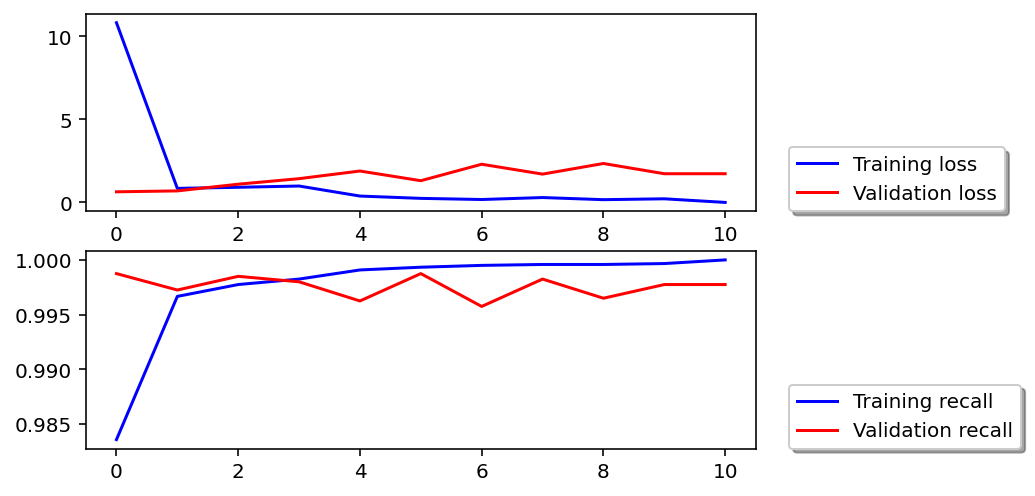

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.1 and 2) RMSprop optimizer(learning rate = 0.01) 
InceptionV3_RMSprop(0.1,0.01,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) RMSprop optimizer(learning rate = 0.1) 
#InceptionV3_RMSprop(0.3,0.1,100)

In [ ]:
# InceptionV3 with 1) dropout layer in the level of 0.3 and 2) RMSprop optimizer(learning rate = 0.01) 
#InceptionV3_RMSprop(0.3,0.01,100)